Acceptance rates:
  mu:     0.301
  sigma2: 0.460
  nu:     0.888


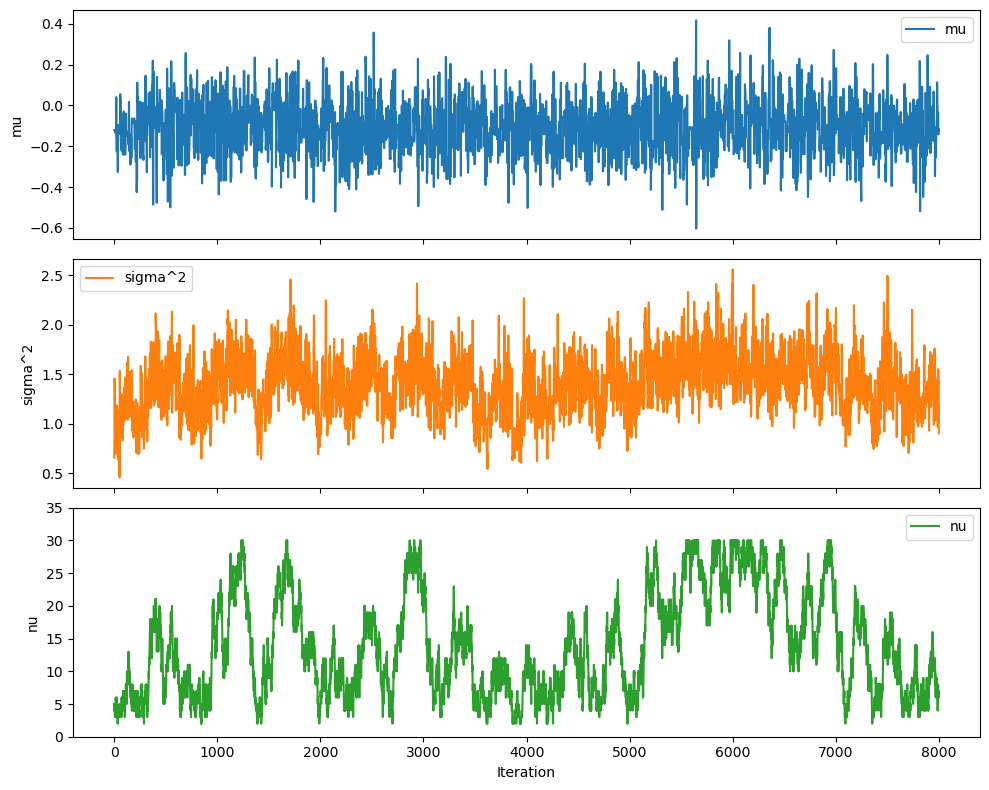

In [5]:
#Q1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ---------------------------------------------------------
# 1) Generate synthetic data from a t-distribution
# ---------------------------------------------------------
np.random.seed(53)
n = 100
true_mu = 0.0
true_sigma2 = 1.0
true_nu = 5

# Generate data x ~ t_nu(true_mu, sqrt(true_sigma2))
x = true_mu + np.sqrt(true_sigma2) * stats.t.rvs(df=true_nu, size=n)

# ---------------------------------------------------------
# 2) Define the log-posterior function
#    p(mu, sigma^2, nu | x) ∝ L(x | mu, sigma^2, nu) × p(mu) × p(sigma^2) × p(nu)
# ---------------------------------------------------------
def log_posterior(mu, sigma2, nu, data):
 
    # 1) Enforce positivity constraint on sigma^2
    if sigma2 <= 0:
        return -np.inf

    # 2) Enforce discrete uniform domain for nu
    if (nu < 2) or (nu > 30):
        return -np.inf

    # ---- Prior for mu: Normal(0, 10)
    log_prior_mu = stats.norm.logpdf(mu, loc=0, scale=10)

    # ---- Prior for sigma^2: 
    #     Suppose sigma ~ HalfNormal(scale=1). Then
    #     p(sigma) = sqrt(2/pi) * exp(-sigma^2/2) for sigma>0
    #     with sigma = sqrt(sigma2),
    #     p(sigma^2) = p(sigma)*|d sigma / d sigma^2| = p(sigma)/(2 sqrt(sigma2))
    #     So log(p(sigma^2)) = log( sqrt(2/pi) ) - sigma^2/2 - log(2 * sigma)
    sigma = np.sqrt(sigma2)
    log_prior_sigma2 = (
        np.log(np.sqrt(2/np.pi))   # log of sqrt(2/pi)
        - 0.5 * sigma**2           # -sigma^2/2
        - np.log(2.0 * sigma)      # - log(2*sigma)
    )

    # ---- Prior for nu: discrete uniform on {2,3,...,30}
    #     Probability mass = 1/29
    log_prior_nu = -np.log(29.0)

    # ---- Likelihood: x_i ~ t_{nu}(mu, sqrt(sigma^2})
    #     We'll sum up logpdf of the t-dist for each data point
    log_lik = np.sum(stats.t.logpdf(data, df=nu, loc=mu, scale=np.sqrt(sigma2)))

    # ---- Return total log-posterior
    return log_prior_mu + log_prior_sigma2 + log_prior_nu + log_lik

# ---------------------------------------------------------
# 3) Metropolis-within-Gibbs Sampler
# ---------------------------------------------------------

# Number of MCMC iterations
N = 10000

# We can set some burn-in and thinning if we like
burnin = 2000
thin   = 1

# Initialize storage arrays
mu_chain     = np.zeros(N)
sigma2_chain = np.zeros(N)
nu_chain     = np.zeros(N)

# Set initial values 
mu_current     = np.mean(x)
sigma2_current = np.var(x)
nu_current     = 5  # or any value in [2,30]
logpost_current = log_posterior(mu_current, sigma2_current, nu_current, x)

# Proposal standard deviations (tune these as needed)
proposal_sd_mu     = 0.5
proposal_sd_sigma2 = 0.5

# Track acceptance rates
accept_mu     = 0
accept_sigma2 = 0
accept_nu     = 0

for i in range(N):
    # --- Update mu (Metropolis) ---
    mu_proposal = np.random.normal(mu_current, proposal_sd_mu)
    logpost_prop = log_posterior(mu_proposal, sigma2_current, nu_current, x)
    
    # Metropolis accept/reject step
    log_alpha = logpost_prop - logpost_current
    if np.log(np.random.rand()) < log_alpha:
        mu_current = mu_proposal
        logpost_current = logpost_prop
        accept_mu += 1

    # --- Update sigma^2 (Metropolis) ---
    sigma2_proposal = np.random.normal(sigma2_current, proposal_sd_sigma2)
    # Must remain positive
    if sigma2_proposal > 0:
        logpost_prop = log_posterior(mu_current, sigma2_proposal, nu_current, x)
        log_alpha = logpost_prop - logpost_current
        if np.log(np.random.rand()) < log_alpha:
            sigma2_current = sigma2_proposal
            logpost_current = logpost_prop
            accept_sigma2 += 1

    # --- Update nu (Discrete) ---
    step_nu = np.random.choice([-1, 1])  # move up or down
    nu_proposal = nu_current + step_nu
    
    # reflect if we step out of bounds
    if nu_proposal < 2:
        nu_proposal = 2
    elif nu_proposal > 30:
        nu_proposal = 30
    
    # If it is actually different, propose a move
    if nu_proposal != nu_current:
        logpost_prop = log_posterior(mu_current, sigma2_current, nu_proposal, x)
        log_alpha = logpost_prop - logpost_current
        if np.log(np.random.rand()) < log_alpha:
            nu_current = nu_proposal
            logpost_current = logpost_prop
            accept_nu += 1

    # Store current draws
    mu_chain[i]     = mu_current
    sigma2_chain[i] = sigma2_current
    nu_chain[i]     = nu_current

# ---------------------------------------------------------
# 4) Posterior samples (after burnin/thin) and trace plots
# ---------------------------------------------------------
mu_post     = mu_chain[burnin::thin]
sigma2_post = sigma2_chain[burnin::thin]
nu_post     = nu_chain[burnin::thin]

# Print acceptance rates
print("Acceptance rates:")
print(f"  mu:     {accept_mu     / N:.3f}")
print(f"  sigma2: {accept_sigma2 / N:.3f}")
print(f"  nu:     {accept_nu     / N:.3f}")

# Plot trace plots (similar to your Figure 1)
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(mu_post, label='mu')
axs[0].set_ylabel('mu')
axs[0].legend()

axs[1].plot(sigma2_post, label='sigma^2', color='tab:orange')
axs[1].set_ylabel('sigma^2')
axs[1].legend()

axs[2].plot(nu_post, label='nu', color='tab:green')
axs[2].set_ylabel('nu')
axs[2].set_xlabel('Iteration')
axs[2].legend()


axs[2].set_ylim(0, 35)

plt.tight_layout()
plt.show()



In [6]:
#Q2
import numpy as np
import pymc as pm
import arviz as az

# ---------------------------------------------------------
# 1) Define a function to generate synthetic t-distributed data
# ---------------------------------------------------------
def generate_t_data(n, true_mu=0.0, true_sigma=1.0, true_nu=5, random_seed=42):
    np.random.seed(random_seed)
    return true_mu + true_sigma * np.random.standard_t(df=true_nu, size=n)

# ---------------------------------------------------------
# 2) Loop over different sample sizes to see effect on nu inference
# ---------------------------------------------------------
sample_sizes = [10, 50, 100]
true_mu = 0.0
true_sigma = 1.0
true_nu = 5

all_traces = {}  # dictionary to store traces for each sample size

for n in sample_sizes:
    print(f"\n=== Running inference for sample size n = {n} ===")
    
    # 2A) Generate data
    data = generate_t_data(n, true_mu, true_sigma, true_nu, random_seed=1234+n)
    
    # 2B) Define the PyMC model
    with pm.Model() as model:
        # mu ~ Normal(0, 10)
        mu = pm.Normal('mu', mu=0.0, sigma=10.0)
        
        # sigma ~ HalfNormal(1)
        sigma = pm.HalfNormal('sigma', sigma=1.0)
        
        # nu ~ DiscreteUniform({2, ..., 30})
        #   In PyMC 4, you specify lower=2, upper=30, but the distribution is inclusive of 2 and 30.
        nu = pm.DiscreteUniform('nu', lower=2, upper=30)
        
        # Observations: StudentT with parameters (nu, mu, sigma)
        obs = pm.StudentT('obs', nu=nu, mu=mu, sigma=sigma, observed=data)
        
        # 2C) Compound step: 
        #     - NUTS for continuous (mu, sigma)
        #     - Metropolis for discrete (nu)
        step1 = pm.NUTS([mu, sigma])
        step2 = pm.Metropolis([nu])
        
        # 2D) Sample from posterior
        #     tune=1000, draws=2000 is just an example; adjust as needed
        trace = pm.sample(
            draws=2000, 
            tune=1000, 
            chains=2, 
            cores=2, 
            step=[step1, step2], 
            return_inferencedata=True
        )
        
        # Store the trace
        all_traces[n] = trace

    # 2E) Summarize results
    print(az.summary(trace, var_names=["mu", "sigma", "nu"], round_to=3))



=== Running inference for sample size n = 10 ===


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     -0.463  0.351  -1.118    0.187      0.007    0.005  2779.802  2005.398   
sigma   1.012  0.260   0.569    1.499      0.005    0.004  2552.090  2099.931   
nu     16.119  7.966   2.000   28.000      0.288    0.204   761.196   775.089   

       r_hat  
mu     1.000  
sigma  1.003  
nu     1.000  

=== Running inference for sample size n = 50 ===


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     -0.044  0.146  -0.324    0.224      0.002    0.002  4481.354  2979.997   
sigma   0.973  0.114   0.782    1.203      0.002    0.002  2727.644  2541.289   
nu     18.530  7.338   7.000   30.000      0.250    0.177   866.470   938.632   

       r_hat  
mu     1.001  
sigma  1.001  
nu     1.001  

=== Running inference for sample size n = 100 ===


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     -0.096  0.119  -0.306    0.136      0.002    0.002  2693.347  2194.281   
sigma   1.092  0.111   0.890    1.302      0.004    0.003   970.283  1129.346   
nu     14.065  7.552   2.000   27.000      0.331    0.234   487.919   501.578   

       r_hat  
mu     1.002  
sigma  1.000  
nu     1.001  


#Q3


## Deriving the Posterior Predictive for $y_i$

We start with the following setup:

1. **Prior on $\,\tau_i$:**

$$
\tau_i \sim \mathrm{Gamma}\!\Bigl(\tfrac{\nu}{2}, \tfrac{\nu}{2}\Bigr).
$$

In rate form, this means

$$
p(\tau_i)
=
\frac{\bigl(\tfrac{\nu}{2}\bigr)^{\tfrac{\nu}{2}}}{\Gamma\!\bigl(\tfrac{\nu}{2}\bigr)}
\,\tau_i^{\tfrac{\nu}{2}-1}
\,\exp\!\Bigl(-\tfrac{\nu}{2}\,\tau_i\Bigr),
\quad \tau_i > 0.
$$

2. **Conditional likelihood**:

$$
y_i \mid \tau_i \;\sim\; \mathcal{N}\!\Bigl(0,\;\tfrac{1}{\tau_i}\Bigr).
$$

Hence,

$$
p(y_i \mid \tau_i)
=
\sqrt{\frac{\tau_i}{2\pi}}
\;\exp\!\Bigl(-\tfrac12\,\tau_i\,y_i^2\Bigr).
$$

We want the **marginal** (or **posterior predictive**) distribution of $y_i$, given by:

$$
p(y_i)
=
\int_{0}^{\infty} p(y_i \mid \tau_i)\;p(\tau_i)\;\mathrm{d}\tau_i.
$$

---

## Step-by-Step Derivation

### 1) Write Out the Integral

Substitute $p(y_i \mid \tau_i)$ and $p(\tau_i)$ into the integral:

$$
\int_0^{\infty} p(y_i \mid \tau_i)\; p(\tau_i)\; \mathrm{d}\tau_i
=
\int_0^{\infty}
\sqrt{\frac{\tau_i}{2 \pi}}
\;\exp\Bigl(-\tfrac{1}{2}\,\tau_i\,y_i^2\Bigr)
\;\times\;
\frac{\Bigl(\tfrac{\nu}{2}\Bigr)^{\tfrac{\nu}{2}}}{\Gamma\!\Bigl(\tfrac{\nu}{2}\Bigr)}
\,\tau_i^{\tfrac{\nu}{2}-1}
\;\exp\Bigl(-\tfrac{\nu}{2}\,\tau_i\Bigr)
\,\mathrm{d}\tau_i.
$$

---

### 2) Combine the Powers of $\,\tau_i$

Observe that

$$
\sqrt{\tau_i}\;\tau_i^{\tfrac{\nu}{2}-1}
=
\tau_i^{\tfrac12}\,\tau_i^{\tfrac{\nu}{2}-1}
=
\tau_i^{\tfrac12 + \tfrac{\nu}{2}-1}
=
\tau_i^{\tfrac{\nu-1}{2}}.
$$

We also combine the exponential terms in $\exp(-\dots\tau_i)$. Any constants not depending on $\tau_i$ can be factored out of the integral.

---

### 3) Recognize the Gamma Kernel

After rearranging, the integrand becomes:

$$
\tau_i^{\tfrac{\nu+1}{2} - 1}
\;\exp\!\Bigl(-\tfrac12\,(\nu + y_i^2)\,\tau_i\Bigr).
$$

This matches the kernel of a **Gamma** distribution with shape $\tfrac{\nu+1}{2}$ and rate $\tfrac12(\nu + y_i^2)$. The integral of this Gamma kernel from $0$ to $\infty$ is:

$$
\frac{\Gamma\!\Bigl(\tfrac{\nu+1}{2}\Bigr)}
{\Bigl[\tfrac12(\nu + y_i^2)\Bigr]^{\tfrac{\nu+1}{2}}}.
$$

---

### 4) Put It All Together

Hence,

$$
p(y_i)
=
\left(\tfrac{\nu}{2}\right)^{\tfrac{\nu}{2}}
\frac{1}{\Gamma\!\Bigl(\tfrac{\nu}{2}\Bigr)\,\sqrt{2\pi}}
\;\times\;
\frac{\Gamma\!\Bigl(\tfrac{\nu+1}{2}\Bigr)}
{\Bigl[\tfrac12(\nu + y_i^2)\Bigr]^{\tfrac{\nu+1}{2}}}.
$$

With algebraic simplifications (factoring out powers of 2, etc.), we obtain the familiar **Student $t$** form:

$$
p(y_i)
=
\frac{\Gamma\!\Bigl(\tfrac{\nu+1}{2}\Bigr)}
{\Gamma\!\Bigl(\tfrac{\nu}{2}\Bigr)\,\sqrt{\nu\pi}}
\left(1 + \frac{y_i^2}{\nu}\right)^{-\tfrac{\nu+1}{2}}.
$$

---

### 5) Final Conclusion

Thus, **integrating out** the Gamma$\bigl(\tfrac{\nu}{2}, \tfrac{\nu}{2}\bigr)$ prior on $\tau_i$ transforms the Normal likelihood into a **Student $t$** distribution. Symbolically:

$$
\boxed{
p(y_i)
=
\int_0^\infty
p(y_i \mid \tau_i)\,p(\tau_i)\,\mathrm{d}\tau_i
=
t_{\nu}(0,1),
}
$$

i.e., a **Student $t$** distribution with $\nu$ degrees of freedom, location 0, and scale 1.

---

**Interpretation**:

- A Normal likelihood with a Gamma$\bigl(\tfrac{\nu}{2}, \tfrac{\nu}{2}\bigr)$ prior on precision is a **scale mixture** that yields a Student $t$ marginal.  
- The parameter $\nu$ in the Gamma prior sets the **degrees of freedom** of the resulting $t$-distribution.
